# Education and Earnings: Unraveling the Impact of Higher Education on Income

Written by:
- Colin Chen
- Cici Liu
- Julian Widjaja
- Thomas Farrell


## 1. Introduction

One of the motivating factors for an individual to seek higher education is the belief that an advanced degree will lead to higher earning potential. But does a degree actually lead to higher earnings? 

A study of 2005 Ontario graduates supports this idea: researchers found statistically significant increases in earnings for each level of university education (Frank and Walters). A study by Kim et al. agreed but found significant variability in earning potential for different genders and fields of study. We will aim to confirm that a higher level of education leads to higher earnings, using a larger and more geographically widespread sample than the Ontario study. 

In this report, we will ask whether a person’s education level had an effect on their chance of earning more than \\$50,000 in 1994. We will investigate whether the proportion of people earning more than \$50,000 is significantly higher for those with a bachelor’s degree versus those without and whether it is again significantly higher for those with a master’s degree.

## 2. Preliminary Results

### Data Cleaning

In [1]:
library('tidyverse')
library("stringr")
library("broom")
library("infer")
options(repr.plot.width=8, repr.plot.height=6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


The dataset we will be using to answer this question is the “Adult” dataset from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult).
We downloaded the dataset to the data folder. Now we read the data from the dataset and store it in `adult_data`.

In [2]:
data_url <- "https://raw.githubusercontent.com/Julian-UBC/project-32/main/data/adult.data"
adult_data <- read.table(data_url, header=FALSE, sep= ",",
                 col.names = c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", 
                               "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "class"))

adult_df <- as.data.frame(apply(adult_data, 2, str_remove_all, " "))

head(adult_df)
nrow(adult_df)
adult_df |> summarize(across(everything(), list(na = ~ sum(is.na(.x)))))

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


[1] 32561

age_na,workclass_na,fnlwgt_na,education_na,education_num_na,marital_status_na,occupation_na,relationship_na,race_na,sex_na,capital_gain_na,capital_loss_na,hours_per_week_na,native_country_na,class_na
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


It contains 32561 observations with information taken from the 1994 US census database, and contains no missing values in any column.

We need to change some variable types before progressing:

In [3]:
dt <- adult_df %>%
    mutate(above_50_k = (class == ">50K"),
          hours_per_week = as.integer(hours_per_week))

Since we are primarily interested in people who received education in schools of learning and researching, we now filter out irrelevant categories in `education`. For our purpose, we also redefine the variable to group people into three segments: people without the bachelor's degree, people with the bachelor's degree, and those who earned a master's degree or higher.

In [4]:
data <- dt %>%
    filter(!education %in% c("Some-college", "Prof-school", "Assoc-acdm", "Assoc-voc")) %>%
    mutate(education = if_else(education == "Doctorate" | education == "Masters", "Master's or higher",
                       if_else(education == "Bachelors", "Bachelor's", "No Bachelor's"))) %>%
    mutate(education = factor(education))

head(data)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class,above_50_k
,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>
1,39,State-gov,77516,Bachelor's,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,FALSE
2,50,Self-emp-not-inc,83311,Bachelor's,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,FALSE
3,38,Private,215646,No Bachelor's,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,FALSE
4,53,Private,234721,No Bachelor's,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,FALSE
5,28,Private,338409,Bachelor's,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,FALSE
6,37,Private,284582,Master's or higher,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,FALSE


### Descriptive Statistics

After data wrangling, we would like to have an insight in the demographic composition of different groups who make either more or less than 50k. These will help us make reasonable decisions in adding more filtering layers to ensure the incomes for people with different education levels are comparative. It will also deepen our understanding to the divergence between groups that might be valuable in later reasoning for the difference.

#### Sample Distribution of Hours of Working

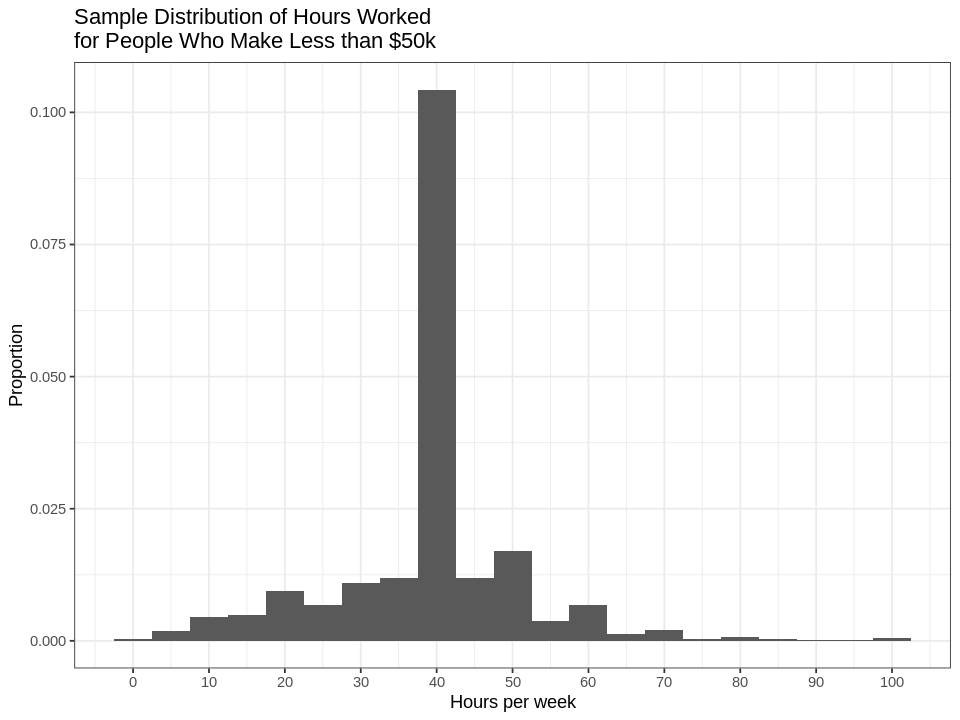

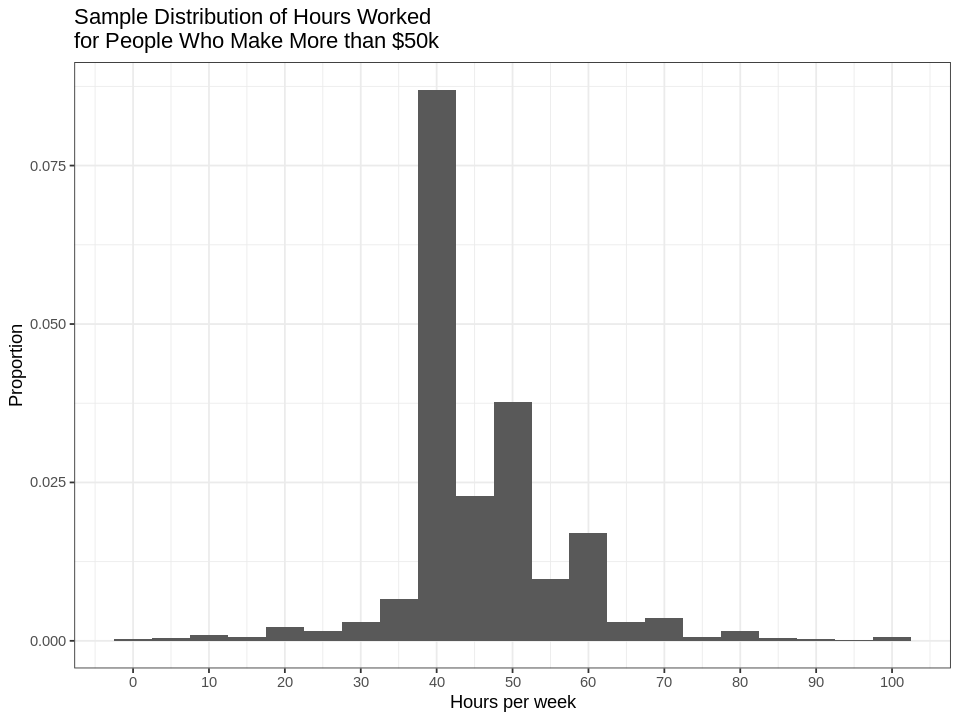

In [5]:
data %>%
    filter(above_50_k == FALSE) %>%
    ggplot() +
    geom_histogram(aes(hours_per_week, ..density..), binwidth = 5) +
    scale_x_continuous(n.breaks = 10) +
    labs(x = "Hours per week", 
         y = "Proportion",
         title = "Sample Distribution of Hours Worked \nfor People Who Make Less than $50k") +
    theme_bw()

data %>%
    filter(above_50_k == TRUE) %>%
    ggplot() +
    geom_histogram(aes(hours_per_week, ..density..), binwidth = 5) +
    scale_x_continuous(n.breaks = 10) +
    labs(x = "Hours per week",
         y = "Proportion",
         title = "Sample Distribution of Hours Worked \nfor People Who Make More than $50k") +
    theme_bw()

From the plots, we see people who make more than $50k tend to spend more hours working than their lower-income counterpart. Specifically, more data are clustered greater than 40 hours for the higher-income group, while there is higher density of data below 40 hours for the lower-income group. To disinvolve the potential confounding variable, we will focus on individuals who work for 40 hours per week.

#### Sample Distribution of Sex

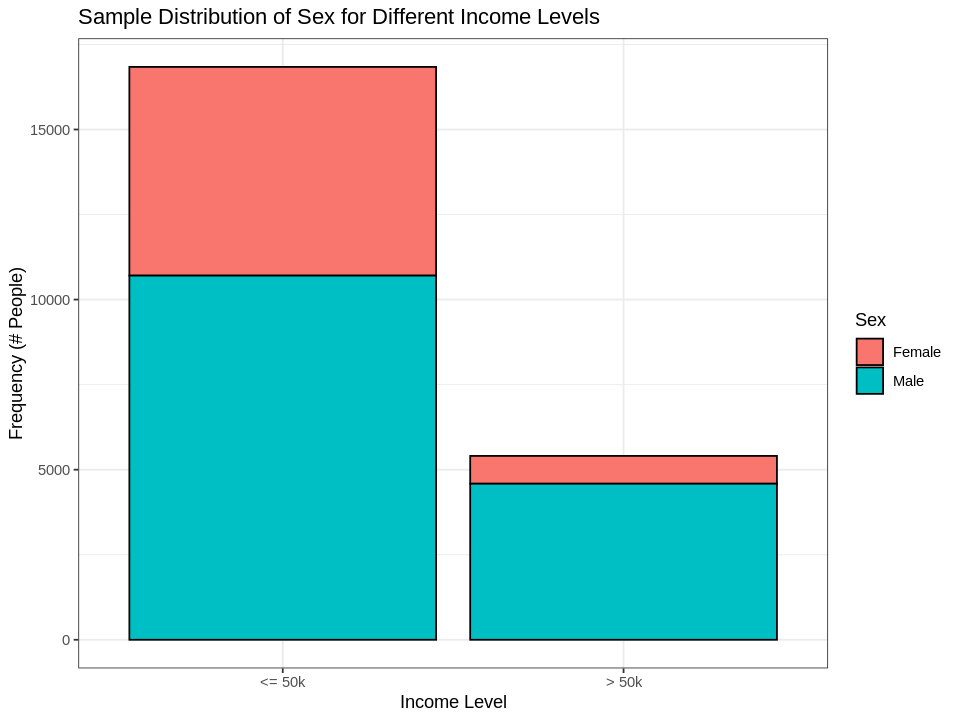

In [6]:
data %>%
    ggplot(aes(x = above_50_k)) +
    geom_bar(aes(fill = sex), position="stack", color='black') +
    scale_x_discrete(labels=c("FALSE" = "<= 50k", "TRUE" = "> 50k")) +
    # geom_text(aes(label = paste0(round((..count../sum(..count..)),2)*100, "%")),
    #         stat = "count",
    #         position = position_stack(vjust = 0.5)) +
    labs(x = "Income Level", 
         y = "Frequency (# People)",
         fill = "Sex",
         title = "Sample Distribution of Sex for Different Income Levels") +
    theme_bw()

The stacked barplot above shows that the proportion of female in the low-income group is much higher than that in the high-income group.

#### Sample Distribution of Race

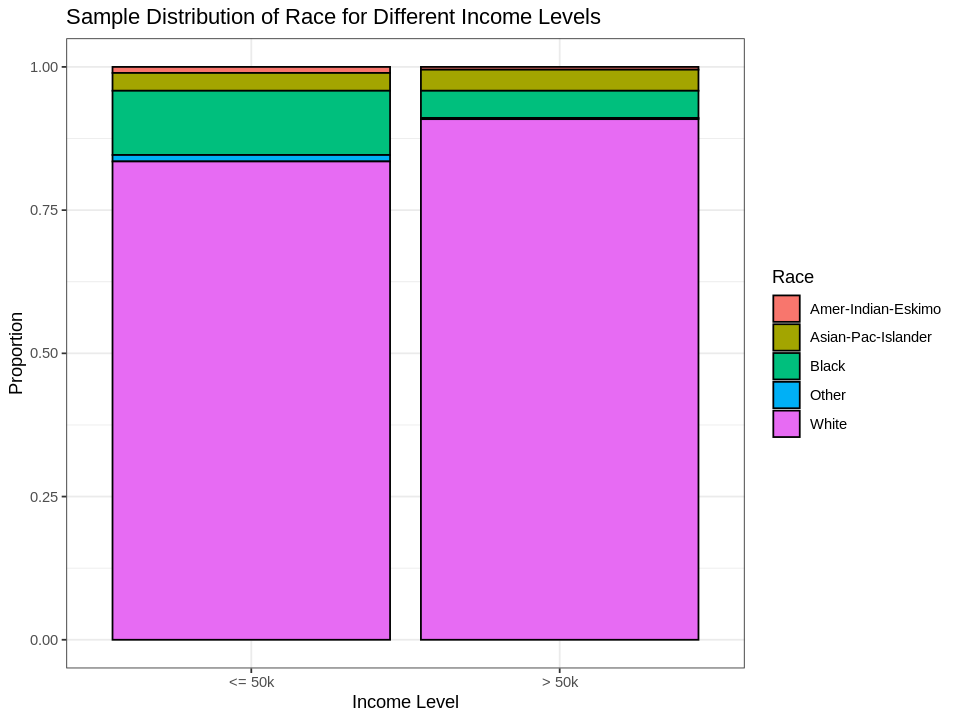

In [7]:
data %>%
    ggplot(aes(x = above_50_k)) +
    geom_bar(aes(fill = race), position="fill", color='black') +
    scale_x_discrete(labels=c("FALSE" = "<= 50k", "TRUE" = "> 50k")) +
    labs(x = "Income Level", 
         y = "Proportion",
         fill = "Race",
         title = "Sample Distribution of Race for Different Income Levels") +
    theme_bw()

The plot shows that the proportion of Black people in the higher-income group is much lower than that in the lower-income group.

#### Paramater of Interest: Education and Income Level

The parameter of our interest is the proportion of people who make more than 50k per year with different educational level. We present them in a summary table here.

In [8]:
# 40 hours of work per week only
data_40 <- data %>%
    filter(hours_per_week == 40)

p_tbl <- data_40 %>%
    group_by(education, above_50_k) %>%
    summarize(prop = n()/nrow(data)) %>%
    group_by(education) %>%
    summarize(above_50_k = above_50_k,
              p = round(prop/sum(prop), 4))

p_tbl %>% filter(above_50_k == TRUE) %>% select(-above_50_k)

`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.


education,p
<fct>,<dbl>
Bachelor's,0.3632
Master's or higher,0.5475
No Bachelor's,0.1294


To visualize the parameter:

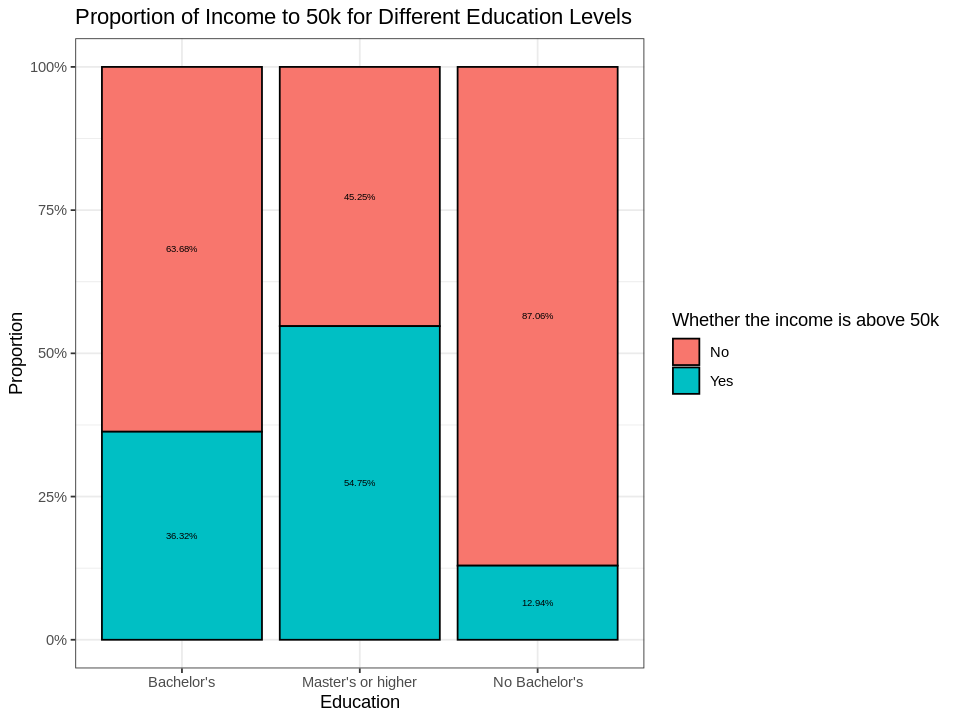

In [9]:
p_tbl %>%
  ggplot(aes(x = education, y = p, fill = above_50_k)) +
  geom_bar(position = "fill", stat = "identity", color='black', width=0.9) +
  scale_y_continuous(labels = scales::percent) +
  geom_text(aes(label = paste0(p*100,"%")), 
            position = position_stack(vjust = 0.5), size = 2) +
  labs(x = "Education",
      y = "Proportion",
      fill = "Whether the income is above 50k",
      title = "Proportion of Income to 50k for Different Education Levels") +
  scale_fill_discrete(labels=c('No', 'Yes')) +
  theme_bw()

Both from the table and the plot, we see a sharp increase in the proportion of people who make more than 50k as people gain higher educational degree. We will use the statistical inferential method to further demonstrate it.

## 3. Methods & Results

The report starts with a clear data cleaning process and clearly defines the parameter of interest and includes descriptive statistics to provide insights. The data is taken from a reliable source through UCI Machine Learning Repository where we have a large sample of an equal representation. However, visualizations and point estimates alone are not sufficient for making informed decisions. To draw robust conclusions, we will conduct a hypothesis test to assess whether the observed differences in the proportions of individuals earning more than $50k across education levels are statistically significant or if they could have occurred due to random chance. We would also include a 95% confidence interval that would give a range of values within which we are 95% confident to help us understand the precision of the estimate. 

Since we are dealing with multiple groups, we will first conduct an ANOVA test to see if the differences in proportions of individuals earning more than $50k are significant.

In [10]:
sample_statistics <- data_40 |>
    group_by(education) |>
    summarize(prop = mean(above_50_k), n = n()) |>
    arrange(prop)
sample_statistics

education,prop,n
<fct>,<dbl>,<int>
No Bachelor's,0.1293915,7543
Bachelor's,0.3632014,2299
Master's or higher,0.5475285,789


In [11]:
aov(above_50_k ~ education, data_40) |> tidy()

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
education,2,192.8483,96.424162,649.8767,5.380854e-267
Residuals,10628,1576.9084,0.148373,NA,NA


From this analysis of variance, at a 0.1% significance level we conclude that at least one of the proportions is different to the others. We will now run paired z-tests to find out which ones are different.

Since the population distribution of whether earning a salary above 50k only takes 0 or 1, we have to rely on the Central Limit Theorem (CLT) for the normality of the sampling distribution. We check if the assumptions for CLT are met:

In [12]:
pooled_p <- function(p1, p2, n1, n2) {
    return((n1*p1 + n2*p2) / (n1 + n2))}

data1 <- data_40 |> filter(education == "Bachelor's" | education == "No Bachelor's")
data2 <- data_40 |> filter(education == "Bachelor's" | education == "Master's or higher")
data3 <- data_40 |> filter(education == "No Bachelor's" | education == "Master's or higher")

assumptions <- tibble(sample = c("Bachelor's vs. None", "Master's vs. Bachelor's", "Master's vs. None"),
                    p_hat = c(pooled_p(sample_statistics$prop[2], sample_statistics$prop[1], sample_statistics$n[2], sample_statistics$n[1]),
                                pooled_p(sample_statistics$prop[3], sample_statistics$prop[2], sample_statistics$n[3], sample_statistics$n[2]),
                                pooled_p(sample_statistics$prop[3], sample_statistics$prop[1], sample_statistics$n[3], sample_statistics$n[1])),
                     n = c(nrow(data1), nrow(data2), nrow(data3))) |>
                mutate(np = p_hat*n, n1_p = (1-p_hat)*n)
                       
assumptions

sample,p_hat,n,np,n1_p
<chr>,<dbl>,<int>,<dbl>,<dbl>
Bachelor's vs. None,0.1840073,9842,1811,8031
Master's vs. Bachelor's,0.4102979,3088,1267,1821
Master's vs. None,0.1689870,8332,1408,6924


From the `np` and `n1_p` columns, we see our sample size is large enough that $n\hat{p}$ and $n(1-\hat{p})$ for all three subgroups that contain two education levels are much larger than 10. Thus, we confirm that the approximation of the sampling distribution under $H_0$ of the test statistic $Z$ by $N(0,1)$ is good.

Now we compute the test statistics $Z$ and its corresponding $p$-values.

In [13]:
test_z <- function(p1, p2, n1, n2) {
    pooled = (n1*p1 + n2*p2) / (n1 + n2)
    return((p1 - p2) / sqrt(pooled*(1 - pooled) * (1/n1 + 1/n2)))
}
test_statistics <- tibble(test = c("Bachelor's vs. None", "Master's vs. Bachelor's", "Master's vs. None"),
                          z = c(test_z(sample_statistics$prop[2], sample_statistics$prop[1], sample_statistics$n[2], sample_statistics$n[1]),
                                test_z(sample_statistics$prop[3], sample_statistics$prop[2], sample_statistics$n[3], sample_statistics$n[2]),
                                test_z(sample_statistics$prop[3], sample_statistics$prop[1], sample_statistics$n[3], sample_statistics$n[1]))) |>
    mutate(p_value = pnorm(-z))
test_statistics

test,z,p_value
<chr>,<dbl>,<dbl>
Bachelor's vs. None,25.328069,7.839183e-142
Master's vs. Bachelor's,9.082232,5.318526e-20
Master's vs. None,29.821120,1.039981e-195


Since we implement three $z$-tests at a time, we do $p$-value correction by using the Bonferroni adjustment.

In [14]:
test_statistics <- test_statistics |>
    mutate(p_value = p.adjust(p_value, method = "bonferroni"))

test_statistics

test,z,p_value
<chr>,<dbl>,<dbl>
Bachelor's vs. None,25.328069,2.351755e-141
Master's vs. Bachelor's,9.082232,1.595558e-19
Master's vs. None,29.821120,3.119944e-195


Again at a 0.1% significance level, we reject all three null hypotheses and conclude that people with bachelor's degrees indeed had a higher chance of earning more than $50,000 annually than people without, and people with master's degrees had a still higher chance.

### Bootstrapping

We want to make sure the result we got using CLT is accurate by using bootstrapping and z-test to compare p value.

First we want to divide `data_40` into 3 sample population based on the education (No Bachelor, Bachelor, and Master or Higher).

In [16]:
data_non_bachelor <- data_40 %>% 
                        filter(education == "No Bachelor's") %>%
                        select(education, above_50_k)
data_bachelor <- data_40 %>% 
                        filter(education == "Bachelor's") %>%
                        select(education, above_50_k)
data_master <- data_40 %>% 
                        filter(education == "Master's or higher") %>%
                        select(education, above_50_k)

head(data_non_bachelor)
head(data_bachelor)
head(data_master)

,education,above_50_k
,<fct>,<lgl>
1,No Bachelor's,FALSE
2,No Bachelor's,FALSE
3,No Bachelor's,FALSE
4,No Bachelor's,FALSE
5,No Bachelor's,FALSE
6,No Bachelor's,FALSE


,education,above_50_k
,<fct>,<lgl>
1,Bachelor's,FALSE
2,Bachelor's,FALSE
3,Bachelor's,TRUE
4,Bachelor's,TRUE
5,Bachelor's,TRUE
6,Bachelor's,FALSE


,education,above_50_k
,<fct>,<lgl>
1,Master's or higher,FALSE
2,Master's or higher,FALSE
3,Master's or higher,TRUE
4,Master's or higher,TRUE
5,Master's or higher,FALSE
6,Master's or higher,TRUE


We want to find the sampling proportion (of people earning more than 50k) of each sample. To achieve that, first we will do a bootstrap on each sample we have. We will use `reps = 1000` here.

In [17]:
n_non_bachelor <- nrow(data_non_bachelor)
n_bachelor <- nrow(data_bachelor)
n_master <- nrow(data_master)

bootstrap_non_bachelor <- data_non_bachelor %>%
    rep_sample_n(size = n_non_bachelor, reps = 1000, replace = TRUE)
bootstrap_bachelor <- data_bachelor %>%
    rep_sample_n(size = n_bachelor, reps = 1000, replace = TRUE)
bootstrap_master <- data_master %>%
    rep_sample_n(size = n_master, reps = 1000, replace = TRUE)

head(bootstrap_non_bachelor)
head(bootstrap_bachelor)
head(bootstrap_master)

replicate,education,above_50_k
<int>,<fct>,<lgl>
1,No Bachelor's,FALSE
1,No Bachelor's,FALSE
1,No Bachelor's,FALSE
1,No Bachelor's,FALSE
1,No Bachelor's,FALSE
1,No Bachelor's,FALSE


replicate,education,above_50_k
<int>,<fct>,<lgl>
1,Bachelor's,FALSE
1,Bachelor's,FALSE
1,Bachelor's,FALSE
1,Bachelor's,FALSE
1,Bachelor's,FALSE
1,Bachelor's,TRUE


replicate,education,above_50_k
<int>,<fct>,<lgl>
1,Master's or higher,FALSE
1,Master's or higher,FALSE
1,Master's or higher,TRUE
1,Master's or higher,TRUE
1,Master's or higher,TRUE
1,Master's or higher,TRUE


Once we have the bootstrap samples for each education levels, we want to calculate the proportion (of people earning more than 50k) of each bootstrap samples for each educations.

In [18]:
bootstrap_dist_non_bachelor <- bootstrap_non_bachelor %>%
    group_by(replicate) %>%
    summarise(prop = mean(above_50_k == "TRUE"))

bootstrap_dist_bachelor <- bootstrap_bachelor %>%
    group_by(replicate) %>%
    summarise(prop = mean(above_50_k == "TRUE"))

bootstrap_dist_master <- bootstrap_master %>%
    group_by(replicate) %>%
    summarise(prop = mean(above_50_k == "TRUE"))

head(bootstrap_dist_non_bachelor)
head(bootstrap_dist_bachelor)
head(bootstrap_dist_master)

replicate,prop
<int>,<dbl>
1,0.1288612
2,0.1288612
3,0.1285960
4,0.1325732
5,0.1303195
6,0.1279332


replicate,prop
<int>,<dbl>
1,0.3688560
2,0.3684211
3,0.3484124
4,0.3449326
5,0.3558069
6,0.3745107


replicate,prop
<int>,<dbl>
1,0.5107731
2,0.5487959
3,0.5234474
4,0.5437262
5,0.5297845
6,0.5335868


Before we calculate p value, we want to visualize how the bootstrap sampling distribution look for each education level.

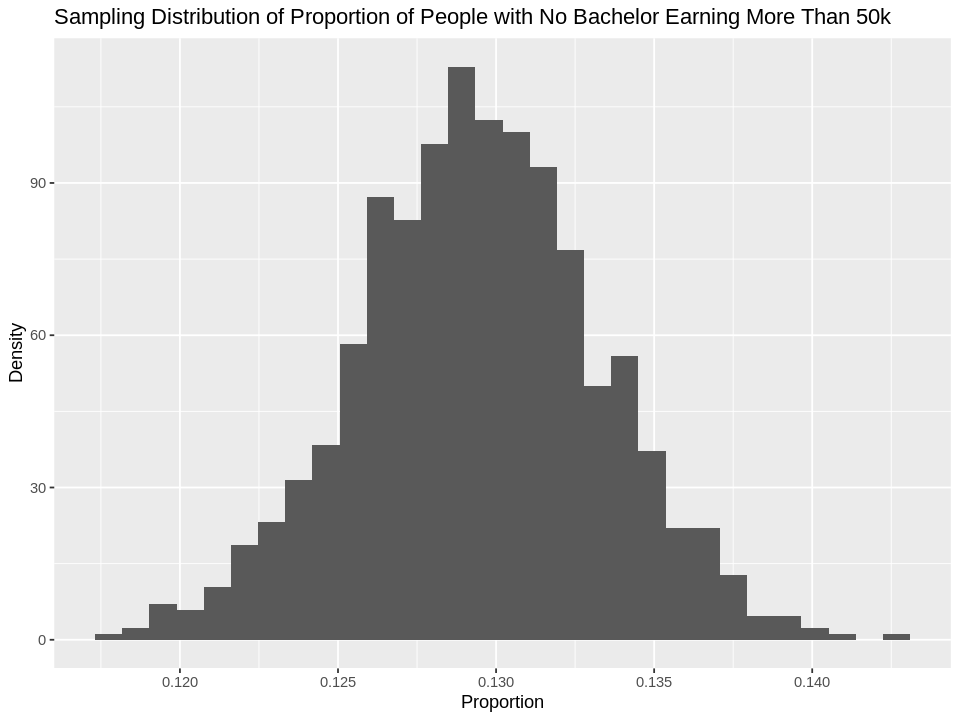

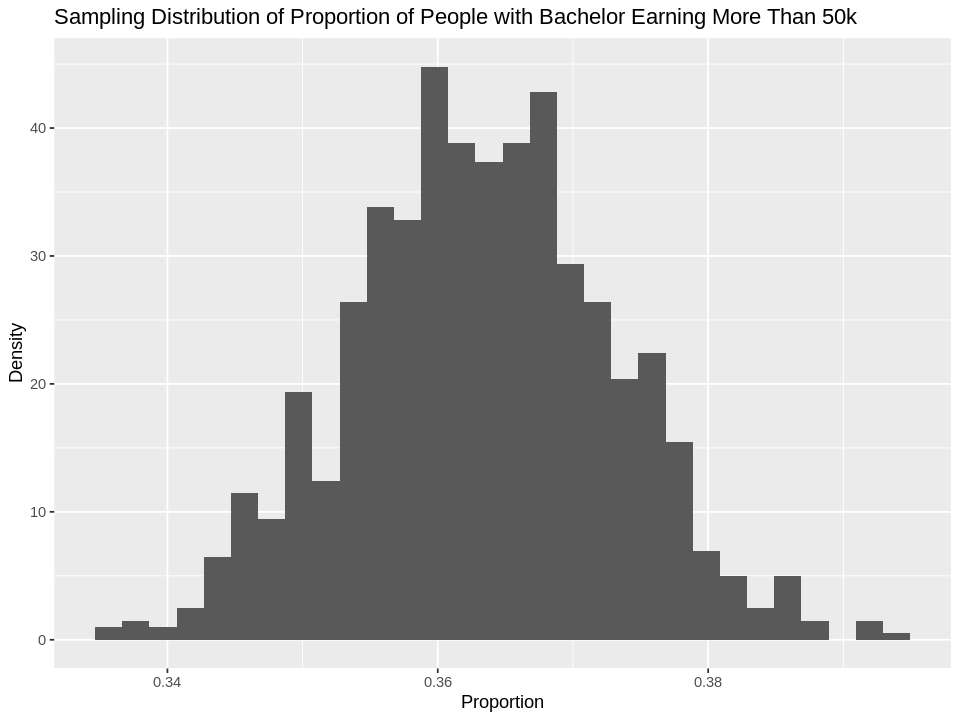

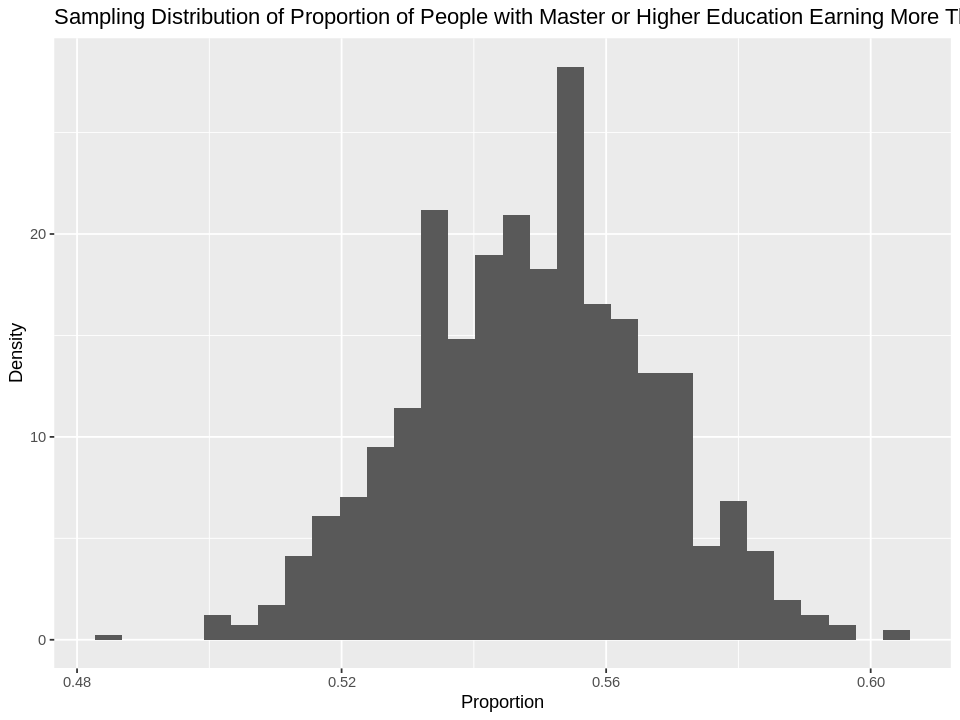

In [19]:
bootstrap_dist_non_bachelor %>%
    ggplot() +
    geom_histogram(aes(x = prop, y = ..density..), bins = 30) +
    labs(x = "Proportion", y = "Density", title = "Sampling Distribution of Proportion of People with No Bachelor Earning More Than 50k")

bootstrap_dist_bachelor %>%
    ggplot() +
    geom_histogram(aes(x = prop, y = ..density..), bins = 30) +
    labs(x = "Proportion", y = "Density", title = "Sampling Distribution of Proportion of People with Bachelor Earning More Than 50k")

bootstrap_dist_master %>%
    ggplot() +
    geom_histogram(aes(x = prop, y = ..density..), bins = 30) +
    labs(x = "Proportion", y = "Density", title = "Sampling Distribution of Proportion of People with Master or Higher Education Earning More Than 50k")

We will first summarize each education's sampling distribution to find the mean of the sampling proportion and the sample size.

In [20]:
bootstrap_summary <- tibble(
    education = c("No Bachelor's", "Bachelor's", "Master's or Higher"),
    sampling_prop = c(mean(bootstrap_dist_non_bachelor$prop), mean(bootstrap_dist_bachelor$prop), mean(bootstrap_dist_master$prop)),
    n = c(n_non_bachelor, n_bachelor, n_master)
)

bootstrap_summary

education,sampling_prop,n
<chr>,<dbl>,<int>
No Bachelor's,0.1294155,7543
Bachelor's,0.3632788,2299
Master's or Higher,0.5488112,789


Now the last step is to calculate the test statistic for each comparison and deduce the p value.

In [24]:
bootstrap_test_statistic <- tibble(
    test = c("No Bachelor's vs Bachelor's", "Bachelor's vs Master's or Higher", "No Bachelor's vs Master's or Higher"),
    z = c(
            test_z(bootstrap_summary$sampling_prop[1], bootstrap_summary$sampling_prop[2], bootstrap_summary$n[1], bootstrap_summary$n[2]),
            test_z(bootstrap_summary$sampling_prop[2], bootstrap_summary$sampling_prop[3], bootstrap_summary$n[2], bootstrap_summary$n[3]),
            test_z(bootstrap_summary$sampling_prop[1], bootstrap_summary$sampling_prop[3], bootstrap_summary$n[1], bootstrap_summary$n[3])
        )
    ) %>%
    mutate(p_value = pnorm(z))


bootstrap_test_statistic

test,z,p_value
<chr>,<dbl>,<dbl>
No Bachelor's vs Bachelor's,-25.331913,7.110904e-142
Bachelor's vs Master's or Higher,-9.140313,3.113596e-20
No Bachelor's vs Master's or Higher,-29.900798,9.606778e-197


Again at a 0.1% significance level, we reject all three null hypotheses and conclude that people with bachelor's degrees indeed had a higher chance of earning more than $50,000 annually than people without, and people with master's degrees had a still higher chance.

We can see that the result from CLT and bootstrapping has similar values and same conclusion.

## Discussions

**Summarize what you found, and the implications/impact of your findings**

ENTER YOUR ANSWER HERE.

**If relevant, discuss whether your results were what you expected to find**

ENTER YOUR ANSWER HERE.

**Discuss future questions/research this study could lead to**

ENTER YOUR ANSWER HERE.

## References

Frank, K., and D. Walters. “Exploring the Alignment Between Postsecondary Education Programs and Earnings: An Examination of 2005 Ontario Graduates”. Canadian Journal of Higher Education, vol. 42, no. 3, Dec. 2012, pp. 93-115, doi:10.47678/cjhe.v42i3.1866.

Kim, ChangHwan, et al. “Field of Study in College and Lifetime Earnings in the United States.” Sociology of Education, vol. 88, no. 4, SAGE Publishing, Sept. 2015, pp. 320–39. https://doi.org/10.1177/0038040715602132.